# Matrix Profile MPlots
> Siguiendo el flujo de 06-mplots-TESTS para intentar usar SCAMP
> + info: https://www.cs.ucr.edu/~eamonn/MatrixProfile.html
>> Recordar que hay un código que no está en matlab. Pedir a Eamonn cuando esté todo más formado

## INSTALL AND USE SCAMP

<div style="border:2px solid red; padding:10px;">
    <strong>⚠️ No eres root! </strong> 
    
    Una vez fijadas las librerías, usar una imagen intermedia que incluya las librerías necesarias. 
    NO modificar la imagen base, porque pesará de manera excesiva y dificulta la vuelta atrás.
   El dockerfile debería ser algo tipo Dockerfile.jupyter.mplots
    
</div>

## Go SCAMP!

#### Mandatory imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
import pyscamp as scamp

### Siguiendo el ejemplo del vídeo de stumpy

In [2]:
import dvats.memory as mem
mem.gpu_memory_status()

GPU | Used mem: 1
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 4%


In [3]:
#Check
#import torch
#torch.cuda.current_device()

### Ejemplo del video de Stumpy

#### Inicializamos los parámetros

In [4]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = scamp.gpu_supported()
has_gpu_support

True

In [5]:
ts = np.random.rand(10000)
m = 50

In [6]:
print("Ts ~ ", ts.shape)
print("Expected mp length: ", int(np.floor(ts.shape[0]-m+1)))

Ts ~  (10000,)
Expected mp length:  9951


In [7]:
# Self join 
mp, index = scamp.selfjoin(ts, m)

In [8]:
mp.shape

(9951,)

In [9]:
index.shape

(9951,)

In [10]:
# AB join using 4 threads, outputting pearson correlation.
ts2 = np.random.rand(10000)
profile, index2 = scamp.abjoin(ts, ts2, m, pearson=True, threads=4)

In [11]:
print("profile ~ ", profile.shape)

profile ~  (9951,)


#### Visualizar el MPlot y la serie temporal

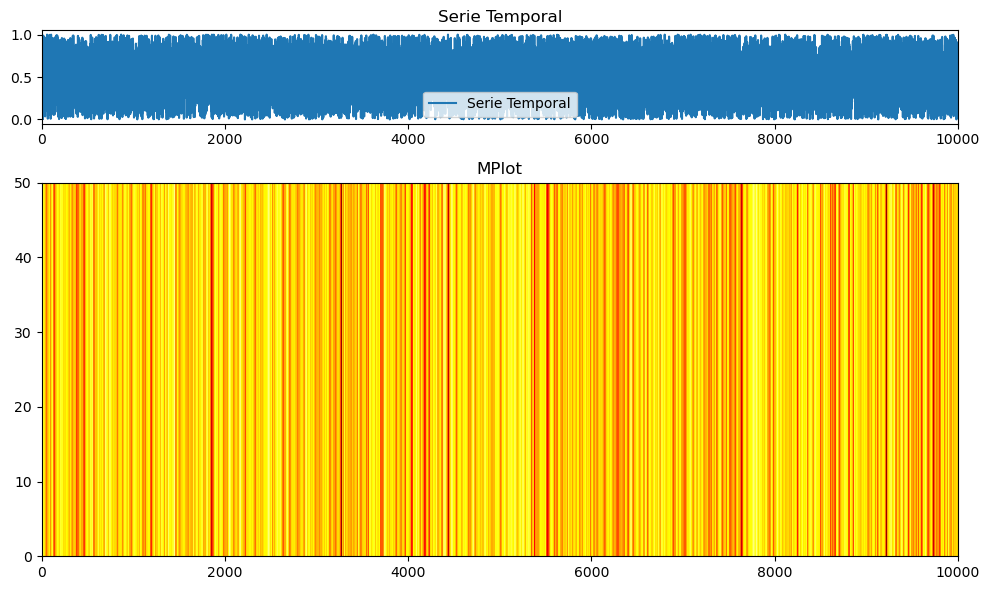

In [12]:
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 1, height_ratios=[1, 4])
# Serie temporal
ax1 = fig.add_subplot(gs[0])
ax1.plot(ts, label="Serie Temporal")
ax1.set_title("Serie Temporal")
ax1.legend()
# MPlot
ax2 = fig.add_subplot(gs[1], sharex=ax1)
mp_values = mp.astype(float) # Extraer solo los valores del perfil de similitud
ax2.imshow(mp_values.reshape(-1, 1).T, aspect='auto', origin='lower', cmap='hot', extent=(0, len(ts), 0, m))
ax2.set_title("MPlot")
plt.tight_layout()
plt.show()

### Ejemplo de STUMPY Basics - Analyzing Motifs and Anomalies with STUMP
https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

Load the dataset

In [14]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


In [15]:
steam_df.shape

(9600, 4)

Visualize dataset

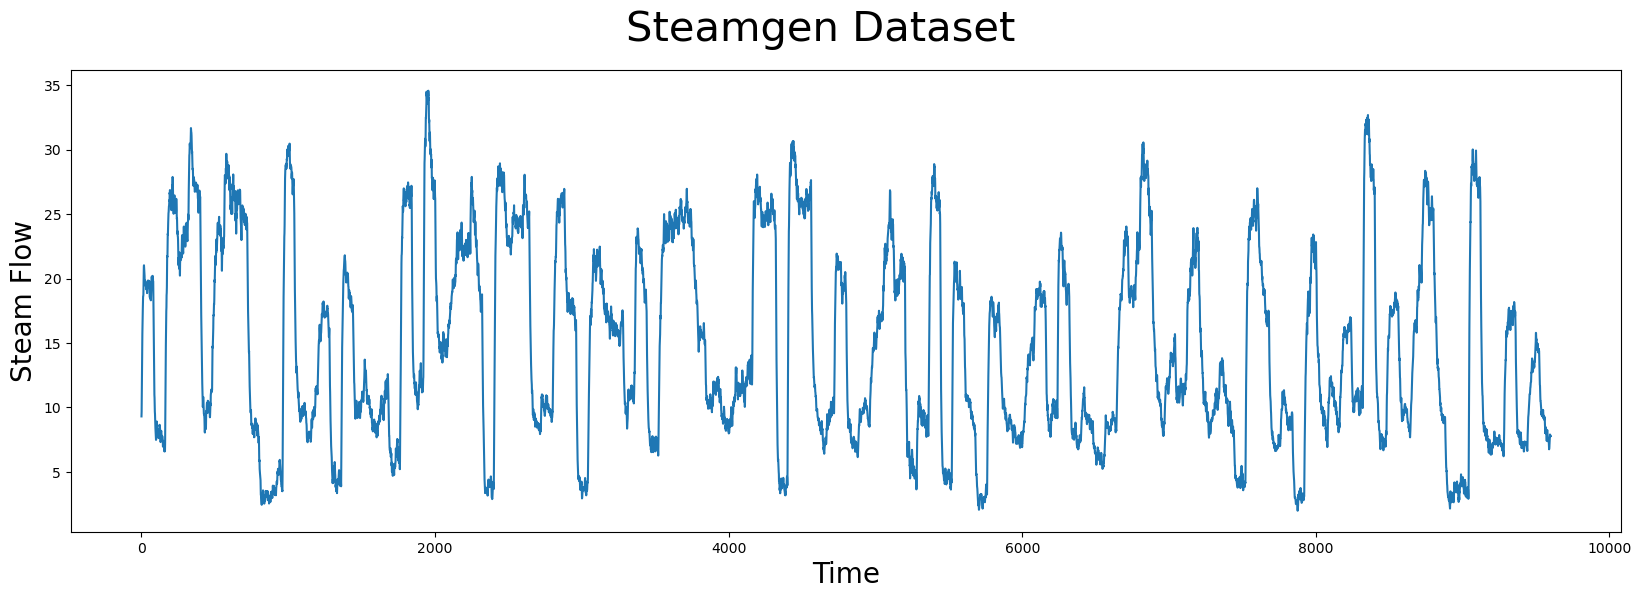

In [16]:
plt.suptitle('Steamgen Dataset', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(steam_df['steam flow'].values)
plt.show()

Manually find a motif

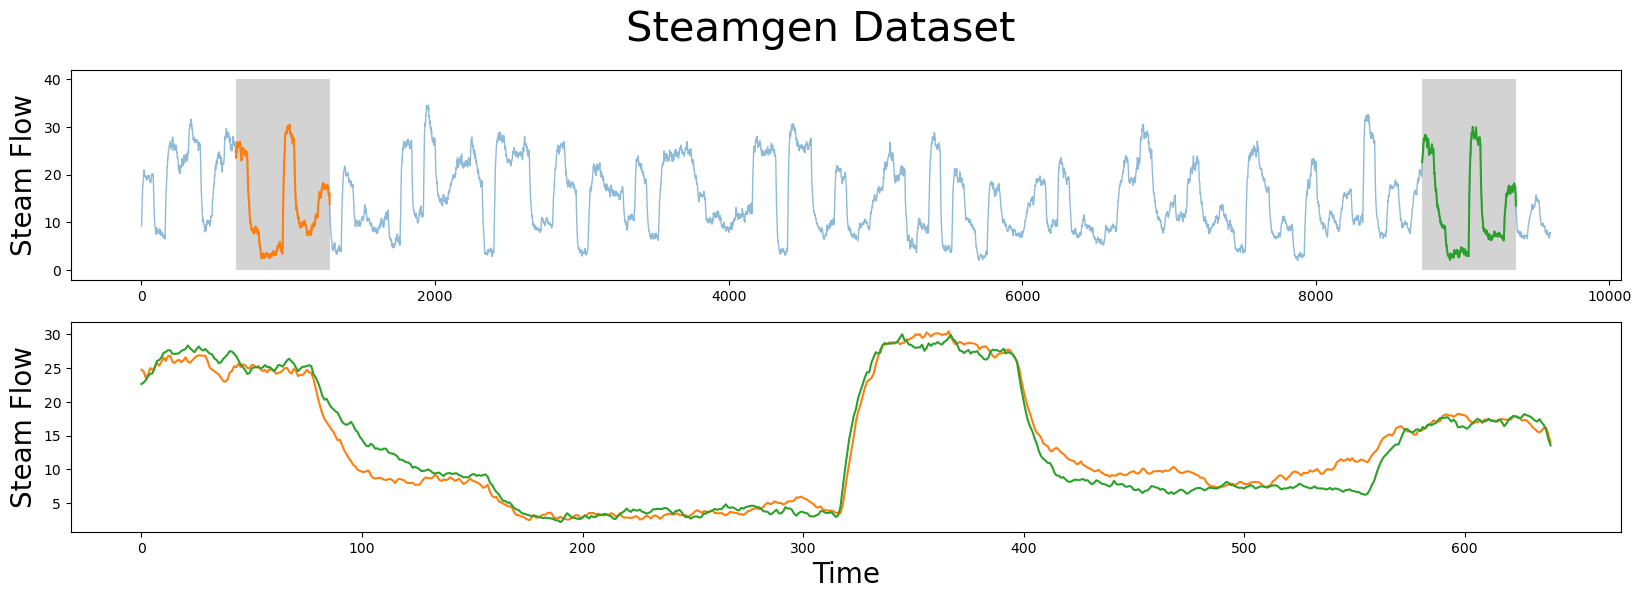

In [17]:
m = 640
fig, axs = plt.subplots(2)
plt.suptitle('Steamgen Dataset', fontsize='30')
axs[0].set_ylabel("Steam Flow", fontsize='20')
axs[0].plot(steam_df['steam flow'], alpha=0.5, linewidth=1)
axs[0].plot(steam_df['steam flow'].iloc[643:643+m])
axs[0].plot(steam_df['steam flow'].iloc[8724:8724+m])
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='20')
axs[1].plot(steam_df['steam flow'].values[643:643+m], color='C1')
axs[1].plot(steam_df['steam flow'].values[8724:8724+m], color='C2')
plt.show()

Find a motif using SCAMP

In [18]:
m = 640
mp, index = scamp.selfjoin(steam_df['steam flow'], m)

- In this case, based on some domain expertise, we’ve chosen ```m = 640```, which is roughly equivalent to half-hour windows.
- And, again, the output of ```scamp.selfjoin``` is an array that contains all of the matrix profile values (i.e., z-normalized Euclidean distance to your nearest neighbor). The matrix profile indices are saved in the index array.
- To identify the index location of the motif we’ll need to find the index location where the matrix profile, ```mp[:, 0]```, has the smallest value:

In [19]:
mp

array([16.23541  , 16.081919 , 15.909404 , ...,  9.02293  ,  9.0382595,
        9.054692 ], dtype=float32)

In [20]:
index.shape

(8961,)

In [21]:
mp[:][0]

16.23541

In [22]:
motif_idx = np.argsort(mp)[0]
print(f"The motif is located at index {motif_idx}")

The motif is located at index 8724


With this ```motif_idx information```, we can also identify the location of its nearest neighbor by cross-referencing the matrix profile indices, ```mp[:, 1]:```

In [23]:
nearest_neighbor_idx = index[motif_idx]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 643


Todo junto

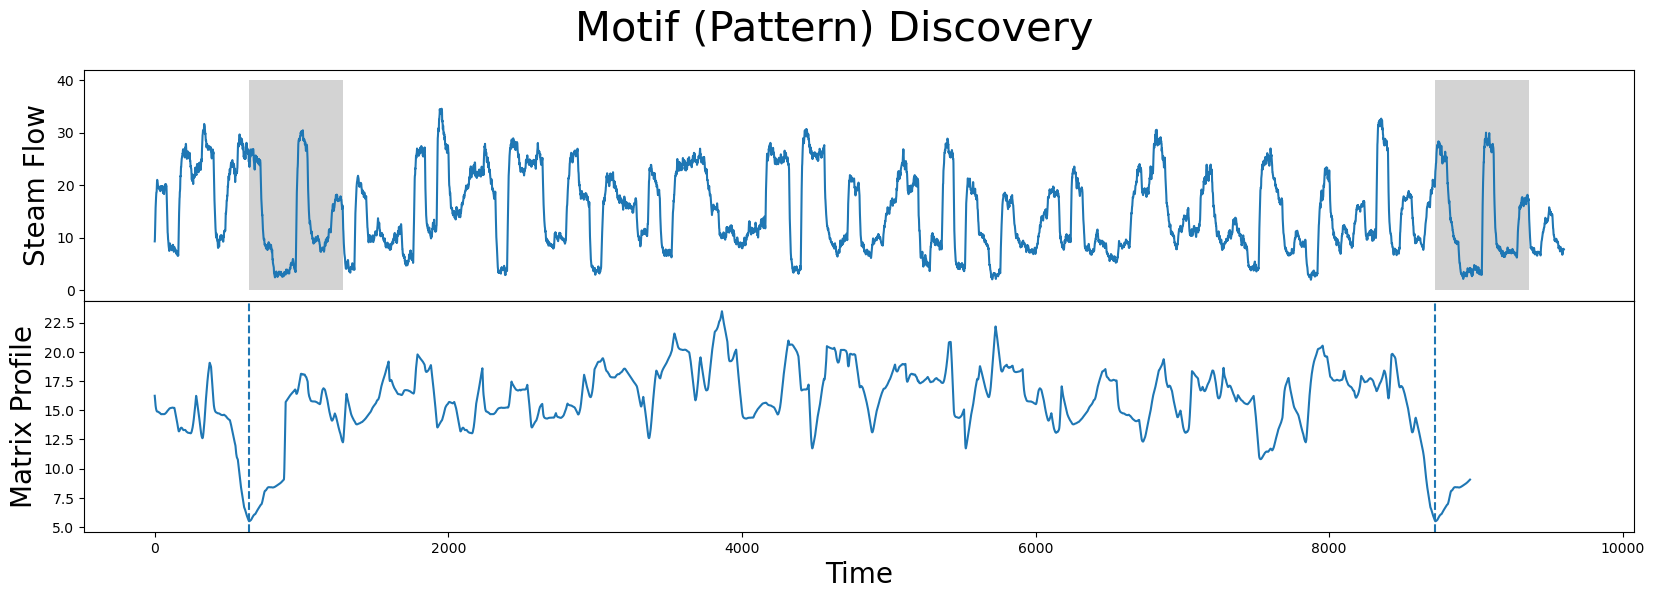

In [24]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp)
plt.show()

What we learn is that the global minima (vertical dashed lines) from the matrix profile correspond to the locations of the two subsequences that make up the motif pair! And the exact z-normalized Euclidean distance between these two subsequences is:

In [25]:
mp[motif_idx]

5.4916167

Discord

In [26]:
discord_idx = np.argsort(mp)[-1]
print(f"The discord is located at index {discord_idx}")

The discord is located at index 3864


In [27]:
mp[discord_idx]

23.476168

In [28]:
nearest_neighbor_distance = index[discord_idx]

print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

The nearest neighbor subsequence to this discord is 4755 units away


The subsequence located at this global maximum is also referred to as a discord, novelty, or “potential anomaly”:

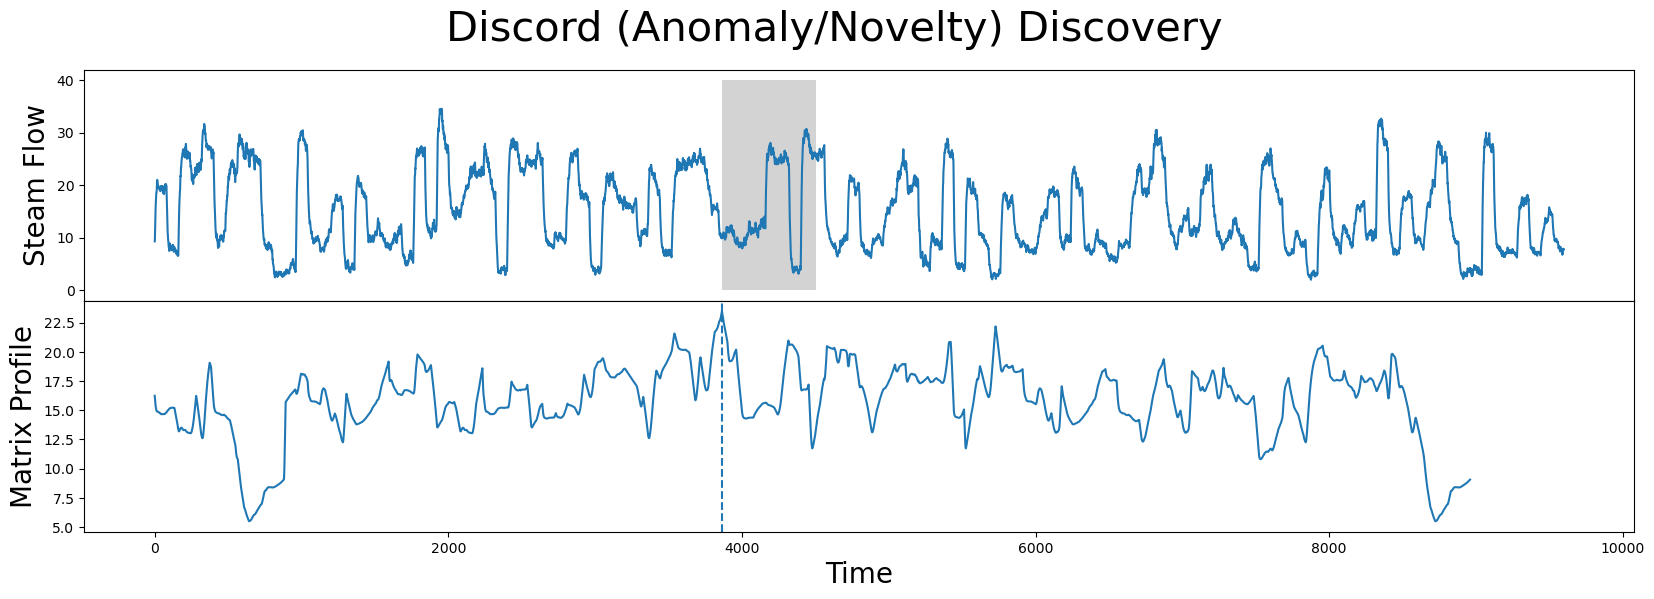

In [29]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='30')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((discord_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(mp)
plt.show()

Intentando ver la matriz Distance Profile al completo

In [30]:
m = 640

In [31]:
steam_flow = steam_df['steam flow'].values
#No nans
steam_flow = [ 0 if np.isnan(x) else x for x in steam_flow ]

In [32]:
reference_idx = np.random.randint(low=0, high=len(steam_flow) - m)
reference_subseq = steam_flow[reference_idx:reference_idx + m]

In [33]:
reference_idx

2499

In [34]:
# Calcular el Distance Profile para cada subsecuencia en la serie temporal
distance_matrix = np.array([
    scamp.abjoin(reference_subseq, steam_flow[i:i + m], m)[0]
    for i in range(len(steam_flow) - m + 1)
])

In [35]:
distance_matrix.shape

(8961, 1)

In [36]:
distance_matrix

array([[37.129833],
       [37.300076],
       [37.470833],
       ...,
       [31.634912],
       [31.473286],
       [31.313782]], dtype=float32)

...Y aquí está el problema! Estás cogiendo solo 1 subsequencia! Es un Distance profile, no un Matrix Profile. Además, el Matrix Profile debería tener una fila por cada DP, lo que significa que lo tenemos traspuesto!!! CUIDADO

In [37]:
n = len (steam_flow) # Numero de puntos de la serie temporal
subsequence_len = 640 # Tamaño ventana
m = subsequence_len

In [38]:
subsequence_len

640

In [39]:
len(steam_flow) - m + 1

8961

In [40]:
# Inicialización de la matriz asociada al MPlot
MPlot_matrix = np.empty((n - m + 1, n - m + 1))

In [44]:
import stumpy
# Calcular el Distance Profile para cada subsecuencia en la serie temporal
distance_matrix = np.array([
    stumpy.core.mass(
        reference_subseq, steam_flow[i:i + m]) 
    for i in range(len(steam_flow) - m + 1)
])

In [47]:
print(len(steam_flow))
print(distance_matrix.shape)
print(MPlot_matrix.shape)

9600
(8961, 1)
(8961, 8961)


In [48]:
#Calculamos el MPlot
for i in range(n - m + 1):
    ### Calculamos el Distance Profile utilizando el algoritmo MASS
    MPlot_matrix[i,:] = stumpy.core.mass(steam_flow[i:i + m], steam_flow)

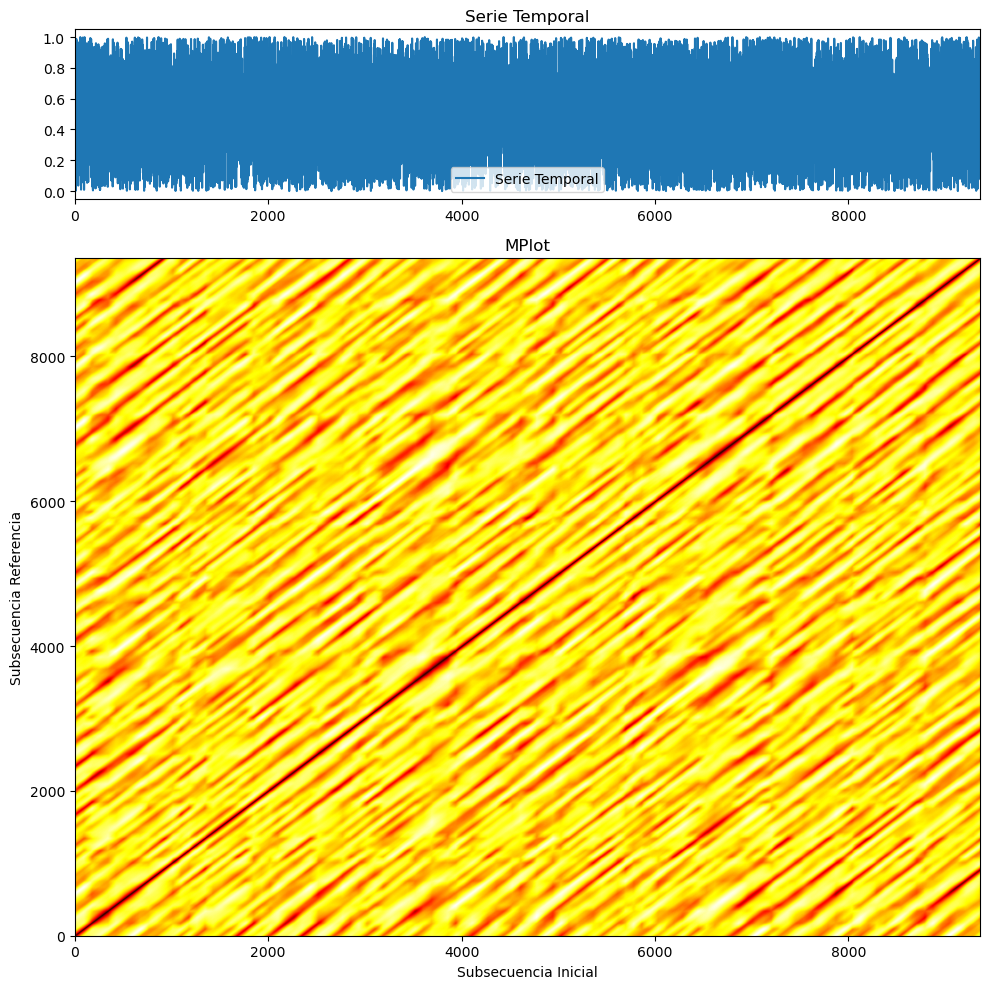

In [49]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Asumiendo que 'ts' es tu serie temporal y 'MPlot_matrix' es la matriz que has calculado
# Asegúrate de que 'ts' y 'MPlot_matrix' están definidos en tu entorno de trabajo

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 1, height_ratios=[1, 4])

# Serie temporal
ax1 = fig.add_subplot(gs[0])
ax1.plot(ts, label="Serie Temporal")
ax1.set_title("Serie Temporal")
ax1.legend()

# MPlot
ax2 = fig.add_subplot(gs[1], sharex=ax1)
# Utilizar 'imshow' para visualizar la matriz MPlot
ax2.imshow(MPlot_matrix, aspect='auto', origin='lower', cmap='hot', extent=(0, len(ts) - m, 0, len(ts) - m))
ax2.set_title("MPlot")
ax2.set_xlabel('Subsecuencia Inicial')
ax2.set_ylabel('Subsecuencia Referencia')

plt.tight_layout()
plt.show()

## Intentando downsamplear como hace Eamonn

In [50]:
### He cogido pyts porque ya la tengo, pero hay que mirar librerías

In [51]:
ts = steam_flow

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PiecewiseAggregateApproximation

In [54]:
n_samples, n_timestamps = 1, len(ts)
print(n_samples)
print(n_timestamps)

1
9600


In [55]:
downsample_factor = 4

In [56]:
expected_size = np.floor(n_timestamps/downsample_factor).astype(int)
expected_size

2400

In [57]:
paa = PiecewiseAggregateApproximation(window_size = downsample_factor) #Creo que es justo lo contrario. Adaptar

In [64]:
ts = np.array(ts)
tss = ts.reshape(1,-1)
tss.shape

(1, 9600)

In [65]:
tss_downsampled = paa.transform(tss)

In [66]:
ts_downsampled = tss_downsampled[0]

In [67]:
# Pues parece que está bien. Y tiene sentido. Porque a cada ventana que 
# avanzamos, quitamos d elementos
ts_downsampled.shape 

(2400,)

In [68]:
def distance_matrix (reference_subseq, ts, m):
    distance_matrix = np.array([
        stumpy.core.mass(reference_subseq, ts[i:i + m]) 
        for i in range(len(ts) - m + 1)
    ])
    return distance_matrix

In [69]:
def mplot_matrix(ts, m): 
    n = ts.shape[0]
    MPlot_matrix = np.empty((n - m + 1, n - m + 1))
    for i in range(n - m + 1):
        ### Calculamos el Distance Profile utilizando el algoritmo MASS
        MPlot_matrix[i,:] = stumpy.core.mass(ts[i:i + m], ts)
    return MPlot_matrix

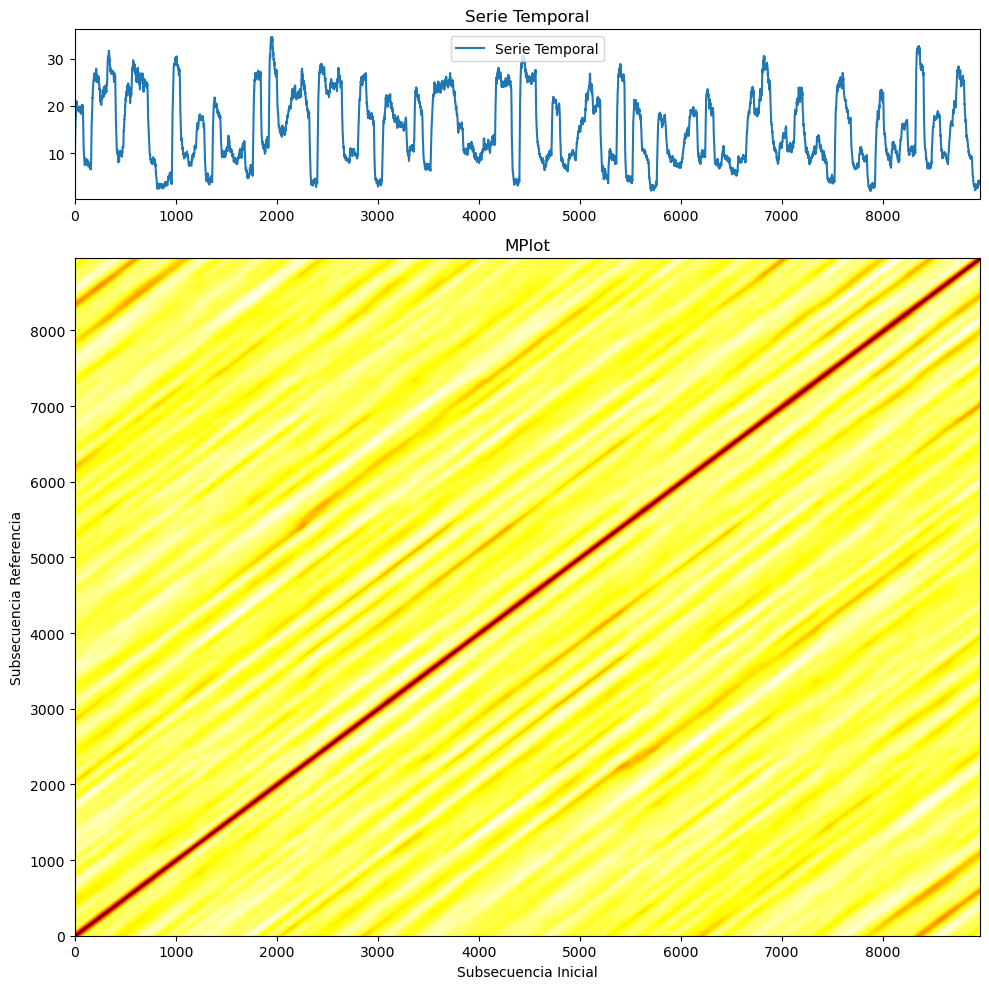

In [70]:
tsd_len = ts_downsampled.shape[0]
m = 640 #Window size
reference_idx = np.random.randint(low=0, high= tsd_len - m)
reference_subseq = ts_downsampled[reference_idx:reference_idx + m]
#distance_matrix = distance_matrix(reference_subseq, ts_downsampled, m)
MPlot_matrix = mplot_matrix(ts_downsampled, m)
# Asumiendo que 'ts' es tu serie temporal y 'MPlot_matrix' es la matriz que has calculado
# Asegúrate de que 'ts' y 'MPlot_matrix' están definidos en tu entorno de trabajo

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 1, height_ratios=[1, 4])

# Serie temporal
ax1 = fig.add_subplot(gs[0])
ax1.plot(ts, label="Serie Temporal")
ax1.set_title("Serie Temporal")
ax1.legend()

# MPlot
ax2 = fig.add_subplot(gs[1], sharex=ax1)
# Utilizar 'imshow' para visualizar la matriz MPlot
ax2.imshow(MPlot_matrix, aspect='auto', origin='lower', cmap='hot', extent=(0, len(ts) - m, 0, len(ts) - m))
ax2.set_title("MPlot")
ax2.set_xlabel('Subsecuencia Inicial')
ax2.set_ylabel('Subsecuencia Referencia')

plt.tight_layout()
plt.show()

In [71]:
import time

In [72]:
def plot_mplot(ts, MPlot_matrix, m):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(2, 1, height_ratios=[1, 4])

    # Serie temporal
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(ts, label="Serie Temporal")
    ax1.set_title("Serie Temporal")
    ax1.legend()

    # MPlot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.imshow(MPlot_matrix, aspect='auto', origin='lower', cmap='hot', extent=(0, len(ts) - m, 0, len(ts) - m))
    ax2.set_title("MPlot")
    ax2.set_xlabel('Subsecuencia Inicial')
    ax2.set_ylabel('Subsecuencia Referencia')

    plt.tight_layout()
    plt.show()

def benchmark_mplot_sizes(ts, min_m, max_m, total_splits):
    distance = np.floor((max_m - min_m)/total_splits)
    window_sizes = [ int(min_m + (i * distance)) for i in range(total_splits) ]
    print(window_sizes)
    for m in window_sizes:  # Ajusta el rango y el paso según sea necesario
        start_time = time.time()
        MPlot_matrix = mplot_matrix(ts, m)
        end_time = time.time()
        print(f"Tiempo de ejecución para m = {m}: {end_time - start_time} segundos")
        plot_mplot(ts, MPlot_matrix, m)

[640, 2080, 3520, 4960]
Tiempo de ejecución para m = 640: 57.86620378494263 segundos


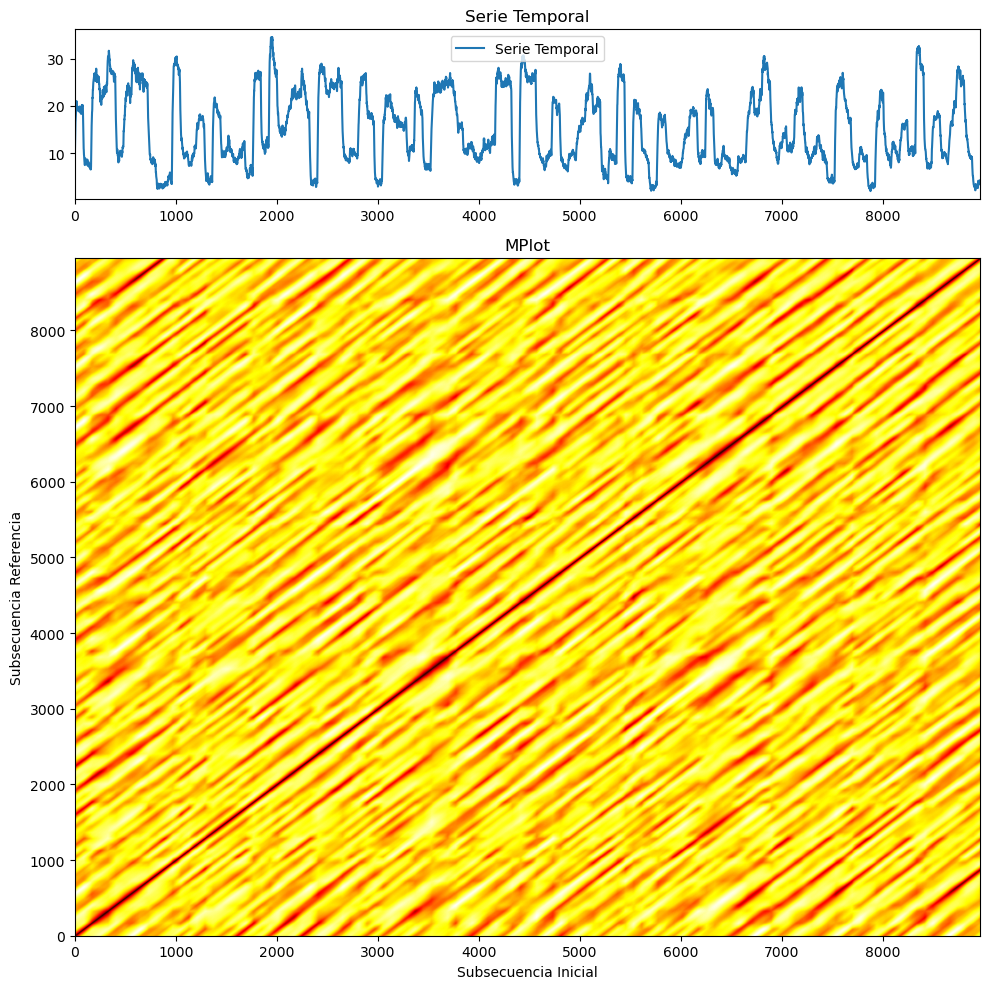

Tiempo de ejecución para m = 2080: 87.805428981781 segundos


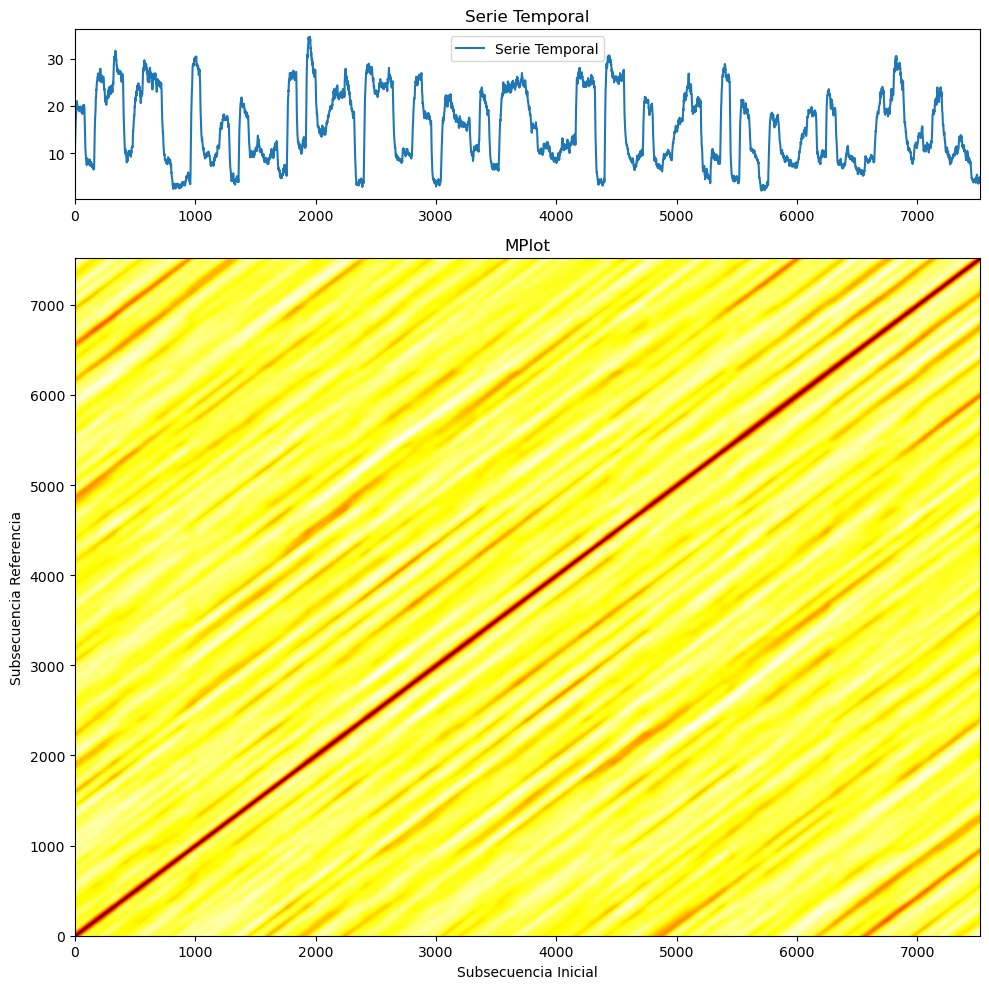

KeyboardInterrupt: 

In [73]:
benchmark_mplot_sizes(ts, 640, 640*10, 4)

...hm... No es exactamente el comportamiento que esperaba con el tiempo de ejecución. Sí que me cuadra el efecto en los plots. Cada vez menos nítido. 

In [74]:
def moving_mean(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_std(x, w):
    return np.sqrt(moving_mean(x**2, w) - moving_mean(x, w)**2)

In [75]:
def splat_check_parameters(
    timeSeriesA, 
    subseqLen, 
    timeSeriesB=None, 
    plotting=False, 
    multiresolution=False, 
    calibration=None
):
    if not isinstance(timeSeriesA, np.ndarray) or timeSeriesA.ndim != 1:
        raise ValueError('First argument must be a 1D numpy array')
    if not (isinstance(subseqLen, int) and 2 <= subseqLen <= len(timeSeriesA)):
        raise ValueError('Subsequence length must be an integer value between 2 and the length of the timeSeries')
    
def splat_resample_timeseries(timeSeriesA, timeSeriesB, selfjoin, max_length):
    if len(timeSeriesA) > max_length or (not selfjoin and len(timeSeriesB) > max_length):
        paa_factor = math.ceil(len(timeSeriesA) / max_length) if len(timeSeriesA) > max_length else math.ceil(len(timeSeriesB) / max_length)
        print(f'Downsampling rate is set to {paa_factor}')
    
        if paa_factor != 1:
            timeSeriesA = pyts.paa(timeSeriesA.reshape(1,-1), math.ceil(len(timeSeriesA) / paa_factor))[0]
            subseqLen = math.ceil(subseqLen / paa_factor)
            if not selfjoin:
                timeSeriesB_newlength = math.floor(len(timeSeriesB) / paa_factor)
                timeSeriesB = pyts.paa(timeSeriesB.reshape(1,-1), timeSeriesB_newlength)

def splat_ensure_timeSeries_integrity(timeSeriesA, timeSeriesB, selfjoin, subseqLen):
    if not selfjoin:
        if not isinstance(timeSeriesB, np.ndarray) or timeSeriesB.ndim != 1:
            raise ValueError('Third argument must be a 1D numpy array')
        timeSeriesA = timeSeriesA.reshape(-1, 1) if timeSeriesA.shape[0] == 1 else timeSeriesA
        timeSeriesB = timeSeriesB.reshape(-1, 1) if timeSeriesB.shape[0] == 1 else timeSeriesB
        timeSeries = np.concatenate((timeSeriesA, timeSeriesB), axis=0)
        subsequenceCountA = len(timeSeriesA) - subseqLen + 1
        subsequenceCountB = len(timeSeriesB) - subseqLen + 1
    else:
        print('Computing Self-join similarity matrix')
        timeSeries = timeSeriesA
    return timeSeries

def splat_compute_df_dg(timeSeries, subseqLen):
    mu = moving_mean(
        np.pad(
            timeSeries[:,0], (subseqLen//2, subseqLen-1-subseqLen//2), 
            'edge'
        ), 
        subseqLen
    )
    invsig = 1. / moving_std(timeSeries.flatten(), subseqLen)
    df = np.diff(timeSeries[:, 0], n = subseqLen, prepend = 0)
    dg = np.diff(timeSeries[:, 0] - mu, n=subseqLen, prepend = 0)
    return df, dg, mu, invsig

def splat(
    timeSeriesA, 
    subseqLen, 
    timeSeriesB=None, 
    plotting=False, 
    multiresolution=False, 
    calibration=None
):
    splat_check_parameters(timeSeriesA, subseqLen, timeSeriesB, plotting, multiresolution, calibration)
    
    max_length = np.inf if not multiresolution else 10000 if calibration is None else getPaaFactor(timeSeriesA, subseqLen)
    minlag = 0
    selfjoin = timeSeriesB is None or np.all(np.isnan(timeSeriesB))
    splat_resample_timeseries(timeSeriesA, timeSeriesB, selfjoin, max_length)
    timeSeries = splat_ensure_timeSeries_integrity(timeSeriesA, timeSeriesB, selfjoin, subseqLen)
    
    n = len(timeSeries)
    timeSeries = timeSeries.reshape(-1, 1) if timeSeries.ndim == 1 else timeSeries
    nanmap = np.isnan(np.convolve(timeSeries[:, 0], np.ones(subseqLen), 'valid'))
    timeSeries[np.isnan(timeSeries)] = 0
    
    df, dg, mu, invsig = splat_compute_df_dg(timeSeries, subseqLen)
    
    # Cálculo de la matriz de similitud
    similarityMatrixLength = n - subseqLen + 1
    if selfjoin:
        similarityMatrix = np.full((similarityMatrixLength, similarityMatrixLength), np.nan)
    else:
        similarityMatrix = np.full((subsequenceCountA, subsequenceCountB), np.nan)
    
    for diag in range(minlag + 1, n - subseqLen + 1):
        cov_ = np.sum((timeSeries[diag:diag + subseqLen, 0] - mu[diag]) * (timeSeries[:subseqLen, 0] - mu[:subseqLen]))
        for row in range(1, n - subseqLen - diag + 2):
            if not selfjoin and row > subsequenceCountA:
                break
            cov_ += df[row] * dg[row + diag - 1] + df[row + diag - 1] * dg[row]
            if selfjoin:
                corr_ = cov_ * invsig[row] * invsig[row + diag - 1]
                similarityMatrix[row, row + diag - 1] = corr_
                similarityMatrix[row + diag - 1, row] = corr_
            elif row + diag - 1 < similarityMatrixLength - subsequenceCountB + 1:
                continue
            else:
                corr_ = cov_ * invsig[row] * invsig[row + diag - 1]
                col = row + diag - 1 - similarityMatrixLength + subsequenceCountB
                similarityMatrix[row, col] = corr_
    
    

In [76]:
print(ts_downsampled.shape)
print(m)

(2400,)
640


In [77]:
MPlot_matrix = splat(ts_downsampled, m, plotting=False)

Computing Self-join similarity matrix


/tmp/ipykernel_20907/963310507.py:88: RuntimeWarning: overflow encountered in scalar multiply
  cov_ += df[row] * dg[row + diag - 1] + df[row + diag - 1] * dg[row]
/tmp/ipykernel_20907/963310507.py:88: RuntimeWarning: invalid value encountered in scalar add
  cov_ += df[row] * dg[row + diag - 1] + df[row + diag - 1] * dg[row]


### Ejemplo que usan en el código de MPlots run_splat de Eamonn Keogh

In [78]:
test_sine = np.concatenate([
    np.random.randn(600)/5,
    np.sin(np.arange(0,10,0.1)),
    np.random.randn(800)/5,
    np.sin(np.arange(0, 10, 0.1)),
    np.random.randn(900)/5,
    np.sin(np.arange(0, 10, 0.05)),
    np.random.randn(800)/5 
]);
#Add a little bit of noise
test_sine = test_sine + np.random.rand(*test_sine.shape) / 10
test_sine.shape

(3500,)

In [ ]:
### Seteamos los parámetros de entrada

In [79]:
x = test_sine

In [80]:
subsequence_length = 100

In [81]:
timeseriesA = np.tile(x, (9, 1)).T

In [82]:
# Inicialización a no numérico
timeseriesB = np.nan 

In [83]:
timeseriesA

array([[-0.26482653, -0.26482653, -0.26482653, ..., -0.26482653,
        -0.26482653, -0.26482653],
       [ 0.05137005,  0.05137005,  0.05137005, ...,  0.05137005,
         0.05137005,  0.05137005],
       [ 0.00068907,  0.00068907,  0.00068907, ...,  0.00068907,
         0.00068907,  0.00068907],
       ...,
       [ 0.12865743,  0.12865743,  0.12865743, ...,  0.12865743,
         0.12865743,  0.12865743],
       [-0.1022385 , -0.1022385 , -0.1022385 , ..., -0.1022385 ,
        -0.1022385 , -0.1022385 ],
       [-0.30574805, -0.30574805, -0.30574805, ..., -0.30574805,
        -0.30574805, -0.30574805]])

In [ ]:
###